In [1]:


# %%


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim



import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from PIL import PILLOW_VERSION
from nltk.stem import WordNetLemmatizer
import spacy
import tensorflow as tf


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
n = 1000


# Any results you write to the current directory are saved as output.


import bert

import itertools

from nltk.stem import WordNetLemmatizer


import nltk
### To install nltk take out comments from next few lines

#import ssl

#try:
#   _create_unverified_https_context = ssl._create_unverified_context
#except AttributeError:
#   pass
#else:
#   ssl._create_default_https_context = _create_unverified_https_context

#nltk.download()

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['background', 'methods', 'introduction', 'conclusions', 'results',
                   'purpose', 'materials', 'discussions','methodology','result analysis'])
# %% Reading Directory

# os.listdir('../Users/raghavkhandelwal/PycharmProjects/Stanford/CORD19_CS_221/CORD-19/')
os.listdir(os.path.expanduser('~/Downloads/CORD19/'))

with open(os.path.expanduser('~/Downloads/CORD19/metadata.readme')) as f:
    data = f.read()
    print(data)


biorxiv_dir = os.listdir(os.path.expanduser('~/Downloads/CORD19/biorxiv_medrxiv/'))
print("Number of articles retrieved from biorxiv:", len(biorxiv_dir))


biorxiv_clean = pd.read_csv(os.path.expanduser('~/Downloads/CORD19/biorxiv_clean.csv'))
clean_comm_use = pd.read_csv(os.path.expanduser('~/Downloads/CORD19/clean_comm_use.csv'))
clean_noncomm_use =  pd.read_csv(os.path.expanduser('~/Downloads/CORD19/clean_noncomm_use.csv'))
clean_pmc =  pd.read_csv(os.path.expanduser('~/Downloads/CORD19/clean_pmc.csv'))

biorxiv_clean.head(2)
clean_comm_use.head(2)
clean_noncomm_use.head(2)
clean_pmc.head(2)
biorxiv_clean.text[0]




from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

stopwords = set(STOPWORDS)
#https://www.kaggle.com/gpreda/cord-19-solution-toolbox

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=30,
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(biorxiv_clean['abstract'], title = 'biorxiv_clean - papers Abstract - frequent words (400 sample)')

df = biorxiv_clean
df = df.abstract.dropna()
data = df.values.tolist()

# *I have downloaded simsentence.csv from version 1's output of this kernel and now using that csv file in cell below for little analysis *
simsentence = pd.read_csv(os.path.expanduser('~/Downloads/CORD19//simsentence.csv'))



def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

print(data_words[:1])


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])


def remove_stopwords(texts):

    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

import spacy
from spacy.lang.en import English
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#or
#spacy.cli.download("en")
nlp = spacy.load('en', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[1])

print(data_lemmatized[:1])


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Topic Modeling
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True
                                        )

#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Computing proplexity and coherence score

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.


2020-11-01

---CHANGES---

No major changes.


---SUMMARY---
total metadata rows: 332458
CORD UIDs (new: 1938, removed: 409)

Full text:
  PDF - 123513 json (new: 549, removed: 3136)
  PMC - 91446 json (new: 2)

---------------------------
2020-10-31

---CHANGES---

No major changes.


---SUMMARY---
total metadata rows: 330801
CORD UIDs (new: 8221, removed: 71)

Full text:
  PDF - 126099 json (new: 1005, removed: 557)
  PMC - 91444 json (new: 474)

---------------------------


2020-10-29

---CHANGES---

No major changes.


---SUMMARY---
total metadata rows: 322441
CORD UIDs (new: 4697, removed: 1314)

Full text:
  PDF - 125651 json (new: 3179, removed: 209)
  PMC - 90970 json (new: 305, removed: 1)

---------------------------
2020-10-28

---CHANGES---

No major changes.


---SUMMARY---
total metadata rows: 320518
CORD UIDs (new: 1290, removed: 409)

Full text:
  PDF - 122679 json (new: 1311, removed: 616)
  PMC - 90666 json (new: 512, removed: 1)

---------------------------
2020-10-

<Figure size 1000x1000 with 1 Axes>

In [2]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

pyLDAvis.save_html(vis, './lda4topics_v2.html')


optimal_model = lda_model

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


[(0,
  '0.110*"patient" + 0.030*"level" + 0.019*"covid" + 0.019*"year" + '
  '0.018*"group" + 0.012*"severe" + 0.012*"symptom" + 0.011*"clinical" + '
  '0.011*"compare" + 0.011*"case" + 0.011*"mycetoma" + 0.010*"day" + '
  '0.010*"cytokine" + 0.010*"infection" + 0.009*"mild" + 0.009*"confirm" + '
  '0.009*"study" + 0.007*"duration" + 0.007*"disease" + 0.007*"preprint"'),
 (1,
  '0.033*"covid" + 0.013*"study" + 0.013*"use" + 0.011*"test" + '
  '0.008*"increase" + 0.007*"non" + 0.007*"high" + 0.006*"factor" + '
  '0.006*"pandemic" + 0.006*"death" + 0.006*"rate" + 0.006*"infection" + '
  '0.005*"abstract" + 0.005*"time" + 0.005*"base" + 0.005*"find" + 0.005*"age" '
  '+ 0.005*"low" + 0.005*"license" + 0.005*"include"'),
 (2,
  '0.024*"model" + 0.019*"case" + 0.016*"transmission" + 0.013*"number" + '
  '0.013*"estimate" + 0.013*"use" + 0.012*"spread" + 0.012*"datum" + '
  '0.011*"epidemic" + 0.011*"infection" + 0.011*"outbreak" + 0.008*"abstract" '
  '+ 0.008*"population" + 0.008*"country"

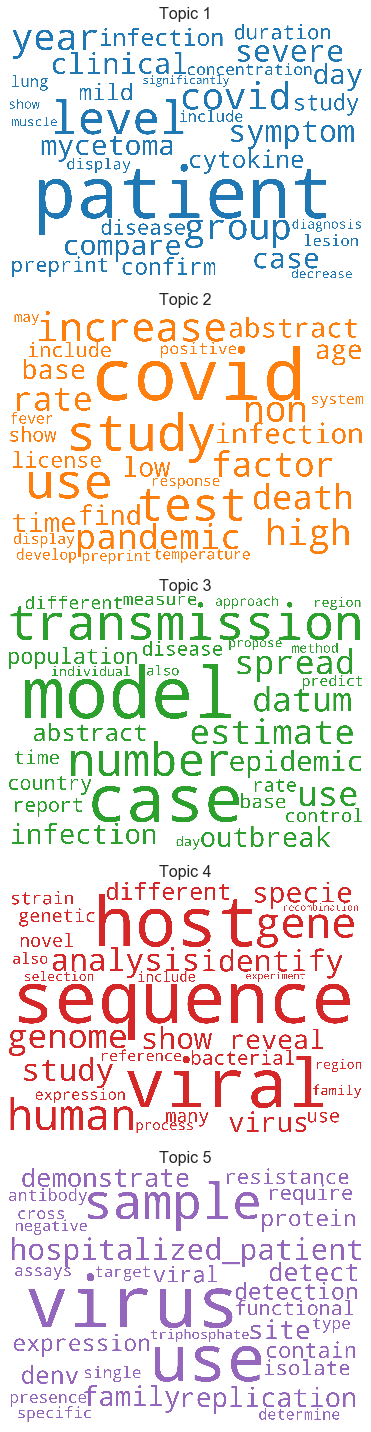

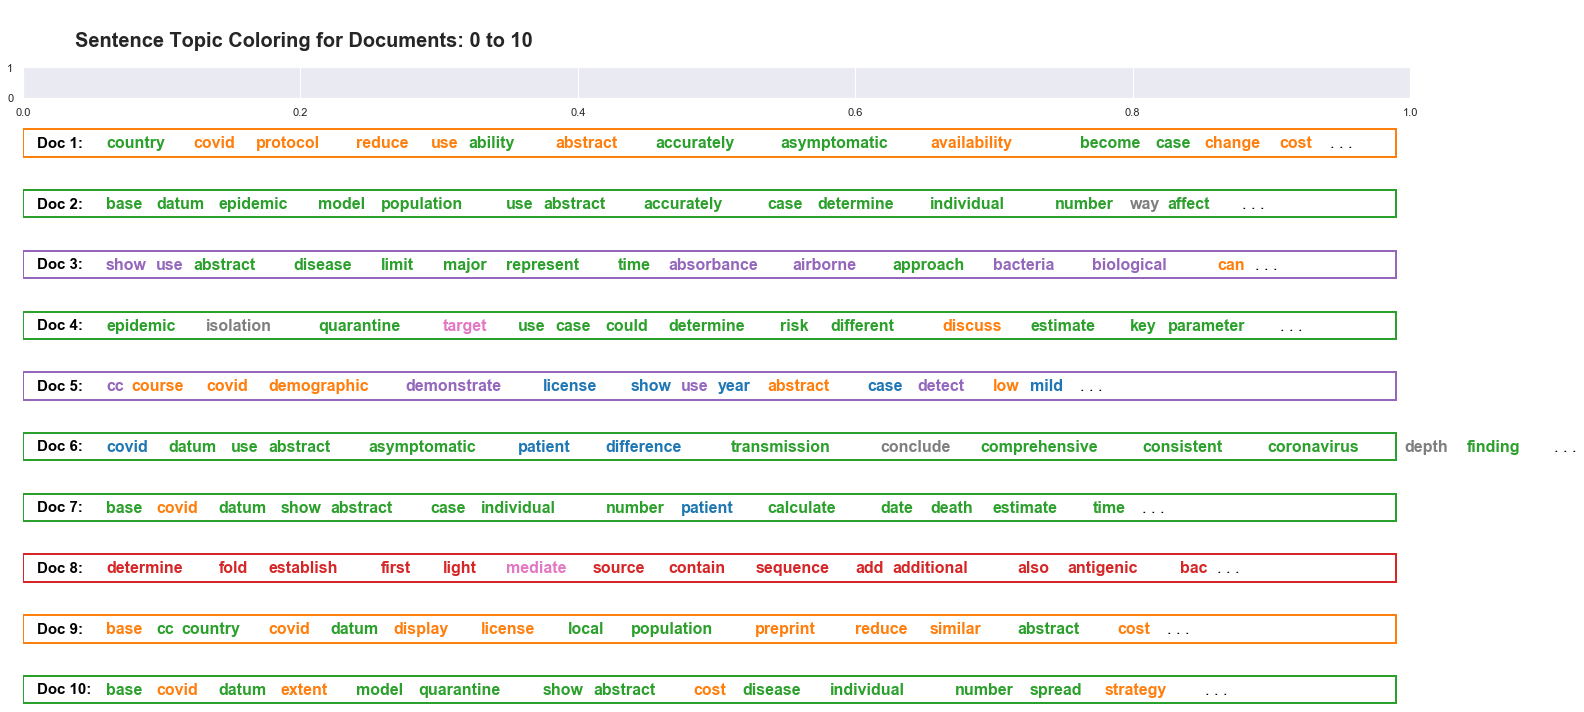

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1230 samples in 0.005s...
[t-SNE] Computed neighbors for 1230 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1230
[t-SNE] Computed conditional probabilities for sample 1230 / 1230
[t-SNE] Mean sigma: 0.075245
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.321518
[t-SNE] KL divergence after 1000 iterations: 0.625994
['model extent age target quarantine can use reduce icu admission cause novel covid use demographic datum demonstrate lower age threshold quarantine year age reduce icu admission drastically show sufficiently strict isolation protocol isolate third country population total month sufficient avoid overwhelming icu capacity entire course epidemic similar result expect hold other country minor adaption will require base local age demographic hospital facility international license make available author funder grant medrxiv license display preprint perpetuity peer 

Loading BokehJS ...

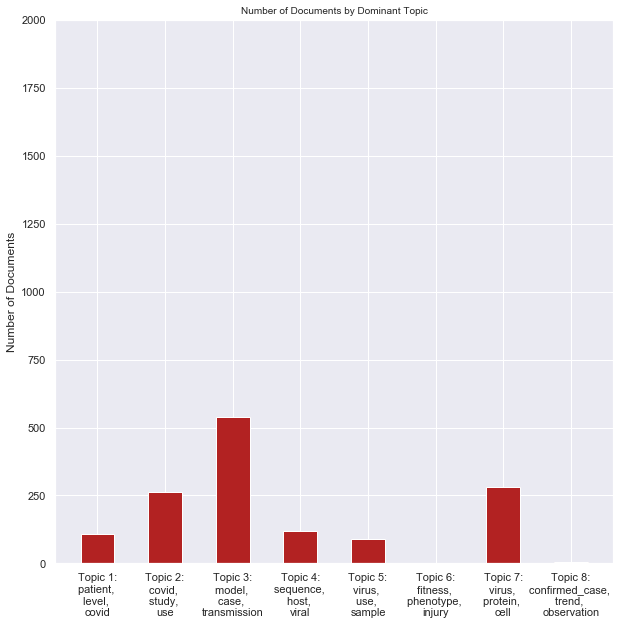

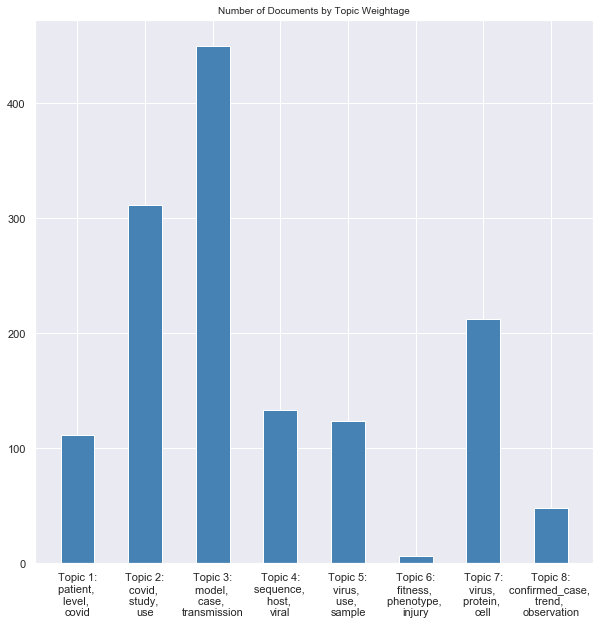

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[2, 1, 4, 3, 6, 0, 5, 7]

In [3]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False,
                               num_words=30)

fig, axes = plt.subplots(5, 1, figsize=(10,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 12):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(22, 10))
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 1:
            #i = i+1
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=15, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += 0.009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=20, x = 0.2, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

corp = corpus[0:13]
corp_cur = corp[13-1]
topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
word_dominanttopic

def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


import bokeh
from bokeh.models import HoverTool
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])


plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              plot_width=800, plot_height=600)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

    # # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # # Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

    # # Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

from matplotlib.ticker import FuncFormatter

# Plot

fig, ax1  = plt.subplots(1, figsize=(10, 10))

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x + 1)+ ':\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 2000)

plt.show()

df_dominant_topic_in_each_doc

fig, ax2  = plt.subplots(1, figsize=(10, 10))
# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

vectorizer = CountVectorizer(analyzer='word', min_df=10,                        # minimum reqd occurences of a word
                              stop_words='english',             # remove stop words
                              lowercase=True,                   # convert all words to lowercase
                              token_pattern='[a-zA-Z0-9]{3,}'  # num chars > 3
                              # max_features=50000,             # max number of uniq words
                             )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(n_jobs=-1)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)


# Do the Grid Search
model.fit(data_vectorized)


best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

categories = list(df.Dominant_Topic.unique())
categories

In [4]:
df1 = clean_comm_use
df1 = df1.dropna()

words = []
for ii in range(0,len(df1)):
    words.append(str(df1.iloc[ii]['text']).split(" "))
    
    
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)
    
    from sklearn.feature_extraction.text import HashingVectorizer

# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**12)

# features matrix X
X = hvec.fit_transform(n_gram_all)

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test = train_test_split(X.toarray(), test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

from sklearn.cluster import KMeans

k = 15 
kmeans = KMeans(n_clusters=k, n_jobs=4, verbose= k)
y_pred = kmeans.fit_predict(X_train)

y_pred.shape

y_train = y_pred
y_test = kmeans.predict(X_test)

%%time
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(X_train)

from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(10,10)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("t-SNE Covid-19 Articles")
# plt.savefig("plots/t-sne_covid19.png")
plt.show()

X_embedded[:,1].shape

# sns settings
sns.set(rc={'figure.figsize':(10,10)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
# plt.savefig("plots/t-sne_covid19_label.png")
plt.show()

type(clean_noncomm_use.abstract.dropna().tolist())

from gensim.summarization.summarizer import summarize
summarize(clean_noncomm_use.abstract.dropna().to_string())






X_train size: 6625
X_test size: 1657 



UsageError: Line magic function `%%time` not found.


In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt') # one time execution
import re

from nltk.tokenize import sent_tokenize
sentences = []
for s in clean_noncomm_use.abstract.dropna():
    sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x] # flatten list

sentences[:3]

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

len(word_embeddings)

# remove punctuations, numbers and special characters
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

# make alphabets lowercase
clean_sentences = [s.lower() for s in clean_sentences]

def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

# remove stopwords from the sentences
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

sentence_vectors = []
for i in clean_sentences:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors.append(v)
    
    # similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])

import torch
torch.cuda.is_available()

%%time
from sklearn.metrics.pairwise import cosine_similarity
for i in range(1000):
    for j in range(1000):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]
            #print(sim_mat[i][j])
            
            
            %%time
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
for i in range(50):
    print(ranked_sentences[i][1])
    print('\n\n')
    
    

In [ ]:
clean_pmc.title

import os
os.listdir('cased_L-12_H-768_A-12')
BERT_VOCAB = 'cased_L-12_H-768_A-12/vocab.txt'
BERT_INIT_CHKPNT = 'cased_L-12_H-768_A-12/bert_model.ckpt'
BERT_CONFIG = 'cased_L-12_H-768_A-12/bert_config.json'

def generate_ngram(seq, ngram = (1, 3)):
    g = []
    for i in range(ngram[0], ngram[-1] + 1):
        g.extend(list(ngrams_generator(seq, i)))
    return g

def _pad_sequence(
    sequence,
    n,
    pad_left = False,
    pad_right = False,
    left_pad_symbol = None,
    right_pad_symbol = None,
):
    sequence = iter(sequence)
    if pad_left:
        sequence = itertools.chain((left_pad_symbol,) * (n - 1), sequence)
    if pad_right:
        sequence = itertools.chain(sequence, (right_pad_symbol,) * (n - 1))
    return sequence


def ngrams_generator(
    sequence,
    n,
    pad_left = False,
    pad_right = False,
    left_pad_symbol = None,
    right_pad_symbol = None,
):
    """
    generate ngrams.

    Parameters
    ----------
    sequence : list of str
        list of tokenize words.
    n : int
        ngram size

    Returns
    -------
    ngram: list
    """
    sequence = _pad_sequence(
        sequence, n, pad_left, pad_right, left_pad_symbol, right_pad_symbol
    )

    history = []
    while n > 1:
        try:
            next_item = next(sequence)
        except StopIteration:
            return
        history.append(next_item)
        n -= 1
    for item in sequence:
        history.append(item)
        yield tuple(history)
        del history[0]

def merge_wordpiece_tokens(paired_tokens, weighted = True):
    new_paired_tokens = []
    n_tokens = len(paired_tokens)

    i = 0

    while i < n_tokens:
        current_token, current_weight = paired_tokens[i]
        if current_token.startswith('##'):
            previous_token, previous_weight = new_paired_tokens.pop()
            merged_token = previous_token
            merged_weight = [previous_weight]
            while current_token.startswith('##'):
                merged_token = merged_token + current_token.replace('##', '')
                merged_weight.append(current_weight)
                i = i + 1
                current_token, current_weight = paired_tokens[i]
            merged_weight = np.mean(merged_weight)
            new_paired_tokens.append((merged_token, merged_weight))

        else:
            new_paired_tokens.append((current_token, current_weight))
            i = i + 1

    words = [
        i[0]
        for i in new_paired_tokens
        if i[0] not in ['[CLS]', '[SEP]', '[PAD]']
    ]
    weights = [
        i[1]
        for i in new_paired_tokens
        if i[0] not in ['[CLS]', '[SEP]', '[PAD]']
    ]
    if weighted:
        weights = np.array(weights)
        weights = weights / np.sum(weights)
    return list(zip(words, weights))

def _extract_attention_weights(num_layers, tf_graph):
    attns = [
        {
            'layer_%s'
            % i: tf_graph.get_tensor_by_name(
                'bert/encoder/layer_%s/attention/self/Softmax:0' % i
            )
        }
        for i in range(num_layers)
    ]

    return attns


from bert import modeling 

def padding_sequence(seq, maxlen, padding = 'post', pad_int = 0):
    padded_seqs = []
    for s in seq:
        if padding == 'post':
            padded_seqs.append(s + [pad_int] * (maxlen - len(s)))
        if padding == 'pre':
            padded_seqs.append([pad_int] * (maxlen - len(s)) + s)
    return padded_seqs


def bert_tokenization(tokenizer, texts, cls = '[CLS]', sep = '[SEP]'):

    input_ids, input_masks, segment_ids, s_tokens = [], [], [], []
    for text in texts:
        tokens_a = tokenizer.tokenize(text)
        tokens = [cls] + tokens_a + [sep]
        segment_id = [0] * len(tokens)
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1] * len(input_id)

        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        s_tokens.append(tokens)

    maxlen = max([len(i) for i in input_ids])
    input_ids = padding_sequence(input_ids, maxlen)
    input_masks = padding_sequence(input_masks, maxlen)
    segment_ids = padding_sequence(segment_ids, maxlen)

    return input_ids, input_masks, segment_ids, s_tokens

class _Model:
    def __init__(self, bert_config, tokenizer):
        _graph = tf.Graph()
        with _graph.as_default():
            self.X = tf.placeholder(tf.int32, [None, None])
            self._tokenizer = tokenizer

            self.model = modeling.BertModel(
                config = bert_config,
                is_training = False,
                input_ids = self.X,
                use_one_hot_embeddings = False,
            )
            self.logits = self.model.get_pooled_output()
            self._sess = tf.InteractiveSession()
            self._sess.run(tf.global_variables_initializer())
            var_lists = tf.get_collection(
                tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'bert'
            )
            self._saver = tf.train.Saver(var_list = var_lists)
            attns = _extract_attention_weights(
                bert_config.num_hidden_layers, tf.get_default_graph()
            )
            self.attns = attns

    def vectorize(self, strings):

        """
        Vectorize string inputs using bert attention.

        Parameters
        ----------
        strings : str / list of str

        Returns
        -------
        array: vectorized strings
        """

        if isinstance(strings, list):
            if not isinstance(strings[0], str):
                raise ValueError('input must be a list of strings or a string')
        else:
            if not isinstance(strings, str):
                raise ValueError('input must be a list of strings or a string')
        if isinstance(strings, str):
            strings = [strings]

        batch_x, _, _, _ = bert_tokenization(self._tokenizer, strings)
        return self._sess.run(self.logits, feed_dict = {self.X: batch_x})

    def attention(self, strings, method = 'last', **kwargs):
        """
        Get attention string inputs from bert attention.

        Parameters
        ----------
        strings : str / list of str
        method : str, optional (default='last')
            Attention layer supported. Allowed values:

            * ``'last'`` - attention from last layer.
            * ``'first'`` - attention from first layer.
            * ``'mean'`` - average attentions from all layers.

        Returns
        -------
        array: attention
        """

        if isinstance(strings, list):
            if not isinstance(strings[0], str):
                raise ValueError('input must be a list of strings or a string')
        else:
            if not isinstance(strings, str):
                raise ValueError('input must be a list of strings or a string')
        if isinstance(strings, str):
            strings = [strings]

        method = method.lower()
        if method not in ['last', 'first', 'mean']:
            raise Exception(
                "method not supported, only support 'last', 'first' and 'mean'"
            )

        batch_x, _, _, s_tokens = bert_tokenization(self._tokenizer, strings)
        maxlen = max([len(s) for s in s_tokens])
        s_tokens = padding_sequence(s_tokens, maxlen, pad_int = '[SEP]')
        attentions = self._sess.run(self.attns, feed_dict = {self.X: batch_x})
        if method == 'first':
            cls_attn = list(attentions[0].values())[0][:, :, 0, :]

        if method == 'last':
            cls_attn = list(attentions[-1].values())[0][:, :, 0, :]

        if method == 'mean':
            combined_attentions = []
            for a in attentions:
                combined_attentions.append(list(a.values())[0])
            cls_attn = np.mean(combined_attentions, axis = 0).mean(axis = 2)

        cls_attn = np.mean(cls_attn, axis = 1)
        total_weights = np.sum(cls_attn, axis = -1, keepdims = True)
        attn = cls_attn / total_weights
        output = []
        for i in range(attn.shape[0]):
            output.append(
                merge_wordpiece_tokens(list(zip(s_tokens[i], attn[i])))
            )
        return output
    
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling  

tokenizer = tokenization.FullTokenizer(vocab_file=BERT_VOCAB, do_lower_case=False)
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)
model = _Model(bert_config, tokenizer)


v = model.vectorize(['hello nice to meet u', 'so long sucker'])
v

model.attention(['hello nice to meet u', 'so long sucker'])


batch_size = 10
ngram = (1, 3)
n_topics = 10

df = clean_pmc
df = df.title.dropna()
negative = df.values.tolist()
negative[0]

negative = negative[:100]

from sklearn.cluster import KMeans
from tqdm import tqdm

rows, attentions = [], []
for i in (range (len(negative))):
          #index = min(i + batch_size, len(negative))
          rows.append(model.vectorize(negative[i]))
          attentions.extend(model.attention(negative[i]))
          
          
stopwords = stop_words   

concat = np.concatenate(rows, axis = 0)
kmeans = KMeans(n_clusters = n_topics, random_state = 0).fit(concat)
labels = kmeans.labels_

overall, filtered_a = [], []
for a in attentions:
    #print(a)
    f = [i for i in a if i[0] not in stopwords]
    overall.extend(f)
    filtered_a.append(f)

o_ngram = generate_ngram(overall, ngram)
features = []
for i in o_ngram:
    #print(i)
    features.append(' '.join([w[0] for w in i]))
features = list(set(features))

components = np.zeros((n_topics, len(features)))
print(n_topics)
#print(features)
for no, i in enumerate(labels):
    if (no + 1) % 500 == 0: 
        print('processed %d'%(no + 1))
    f = generate_ngram(filtered_a[no], ngram)
    for w in f:
        word = ' '.join([r[0] for r in w])
        score = np.mean([r[1] for r in w])
        if word in features:
            components[i, features.index(word)] += score
            
def print_topics_modelling(
    topics, feature_names, sorting, n_words = 20, return_df = True
):
    if return_df:
        try:
            import pandas as pd
        except:
            raise Exception(
                'pandas not installed. Please install it and try again or set `return_df = False`'
            )
    df = {}
    for i in range(topics):
        words = []
        for k in range(n_words):
            words.append(feature_names[sorting[i, k]])
        df['topic %d' % (i)] = words
    if return_df:
        return pd.DataFrame.from_dict(df)
    else:
        return df
    
    
print_topics_modelling(
    10,
    feature_names = np.array(features),
    sorting = np.argsort(components)[:, ::-1],
    n_words = 10,
    return_df = True,
)


In [ ]:
!pip install -U transformers
!pip install -U torch

import torch
import os
import json
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

BART_PATH = 'bart-large'
bart_model = BartForConditionalGeneration.from_pretrained(BART_PATH, output_past=True)

bart_tokenizer = BartTokenizer.from_pretrained(BART_PATH)

def bart_summarize(input_text, num_beams=4, num_words=80):
    #input_text = str(input_text)
    input_text = ' '.join(input_text.split())
    input_tokenized = bart_tokenizer.encode(input_text, return_tensors='pt')
    summary_ids = bart_model.generate(input_tokenized,
                                      num_beams=int(num_beams),
                                      no_repeat_ngram_size=3,
                                      length_penalty=2.0,
                                      min_length=100,
                                      max_length=int(num_words),
                                      early_stopping=True)
    output = [bart_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    return output[0]

df = clean_pmc
df = df.abstract.dropna()
abstracts = df.values.tolist()

len(abstracts)

%%time
for i in range(20):
    try:
        print('paper  ',i + 1, " : \n" )
        print(bart_summarize(abstracts[i]))
        print('............................................................................\n\n\n\n')
    except:
        print('paper ',i+1 ," has LONG ABSTRACT\n\n")
        
        
df1 = biorxiv_clean
df1 = df1.abstract.dropna()
df1abstracts = df.values.tolist()

len(df1abstracts)

T5_PATH = 't5-base'
t5_model = T5ForConditionalGeneration.from_pretrained(T5_PATH, output_past=True)
t5_tokenizer = T5Tokenizer.from_pretrained(T5_PATH)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def t5_summarize(input_text, num_beams=4, num_words=80):
    #input_text = str(input_text).replace('\n', '')
    input_text = ' '.join(input_text.split())
    input_tokenized = t5_tokenizer.encode(input_text, return_tensors="pt").to(device)
    summary_task = torch.tensor([[21603, 10]]).to(device)
    input_tokenized = torch.cat([summary_task, input_tokenized], dim=-1).to(device)
    summary_ids = t5_model.generate(input_tokenized,
                                    num_beams=int(num_beams),
                                    no_repeat_ngram_size=3,
                                    length_penalty=2.0,
                                    min_length=30,
                                    max_length=int(num_words),
                                    early_stopping=True)
    output = [t5_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    return output[0]


%%time
for i in range(20):
    try:
        print('BioArvix paper  ',i + 1, " : \n" )
        print(t5_summarize(df1abstracts[i]))
        print('............................................................................\n\n\n\n')
    except:
        print('paper ',i+1 ," has LONG ABSTRACT\n\n")

!pip install sentence-transformers
"""
This is a simple application for sentence embeddings: semantic search
We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.
This script outputs for various queries the top 5 most similar sentences in the corpus.
"""
# taken from : https://github.com/UKPLab/sentence-transformers/blob/master/examples/application_semantic_search.py
from sentence_transformers import SentenceTransformer
import scipy.spatial

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

# Corpus with example sentences
corpus = simsentence.similar.tolist()
corpus_embeddings = embedder.encode(corpus)

# Query sentences:
queries = ['Range of incubation periods for the disease in humans', 'antiviral covid-19 success treatment','virus detected from animals?', 'risk of fatality among symptomatic hospitalized patients']
query_embeddings = embedder.encode(queries)

# Find the closest  sentences of the corpus for each query sentence based on cosine similarity
closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences from similar")

    for idx, distance in results[0:closest_n]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))
        
        
"""
This is a simple application for sentence embeddings: semantic search
We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.
This script outputs for various queries the top 5 most similar sentences in the corpus.
"""
# taken from : https://github.com/UKPLab/sentence-transformers/blob/master/examples/application_semantic_search.py
from sentence_transformers import SentenceTransformer
import scipy.spatial

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

# Corpus with example sentences
corpus = df.values.tolist()
corpus_embeddings = embedder.encode(corpus)

# Query sentences:
queries = ['Range of incubation periods for the disease in humans','risk factors of covid-19','cure for covid-19', 'antiviral covid-19 success treatment','Does smoking or pre-existing pulmonary disease increase risk of COVID-19?', 'risk of fatality among symptomatic hospitalized patients']
query_embeddings = embedder.encode(queries)

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))        

In [ ]:
!pip install transformers

%%time
import os
import tqdm
import textwrap
import json
import prettytable
import logging
import pickle
import warnings
warnings.simplefilter('ignore')

from  transformers import *
import pandas as pd
import scipy
from sentence_transformers import SentenceTransformer

COVID_BROWSER_ASCII = """
================================================================================
  _____           _     _      __  ___    ____                                  
 / ____|         (_)   | |    /_ |/ _ \  |  _ \                                 
| |     _____   ___  __| | ___ | | (_) | | |_) |_ __ _____      _____  ___ _ __ 
| |    / _ \ \ / / |/ _` ||___|| |\__, | |  _ <| '__/ _ \ \ /\ / / __|/ _ \ '__|
| |___| (_) \ V /| | (_| |     | |  / /  | |_) | | | (_) \ V  V /\__ \  __/ |   
 \_____\___/ \_/ |_|\__,_|     |_| /_/   |____/|_|  \___/ \_/\_/ |___/\___|_|   
=================================================================================
"""

COVID_BROWSER_INTRO = """
This demo uses a state-of-the-art language model trained on scientific papers to
search passages matching user-defined queries inside the COVID-19 Open Research
Dataset. Ask something like 'Is smoking a risk factor for Covid-19?' to retrieve
relevant abstracts.\n
"""

BIORXIV_PATH = '/kaggle/input/CORD-19-research-challenge//biorxiv_medrxiv/biorxiv_medrxiv/'
COMM_USE_PATH = '/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/'
NONCOMM_USE_PATH = '/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/'
METADATA_PATH = '/kaggle/input/CORD-19-research-challenge/metadata.csv'

DATA_PATH = '/kaggle/input/CORD-19-research-challenge/'
MODELS_PATH = 'models'
MODEL_NAME = 'scibert-nli'
CORPUS_PATH = os.path.join(DATA_PATH, 'corpus.pkl')
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME)
EMBEDDINGS_PATH = os.path.join(DATA_PATH, f'{MODEL_NAME}-embeddings.pkl')


def load_json_files(dirname):
    filenames = [file for file in os.listdir(dirname) if file.endswith('.json')]
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    print('Loaded', len(raw_files), 'files from', dirname)
    return raw_files


def create_corpus_from_json(files):
    corpus = []
    for file in tqdm(files):
        for item in file['abstract']:
            corpus.append(item['text'])
        for item in file['body_text']:
            corpus.append(item['text'])
    print('Corpus size', len(corpus))
    return corpus


def cache_corpus(mode='CSV'):
    corpus = []
    if mode == 'CSV':
        df = pd.read_csv(METADATA_PATH)
        corpus = [a for a in df['abstract'] if type(a) == str and a != "Unknown"]
        print('Corpus size', len(corpus))
    elif mode == 'JSON':
        biorxiv_files = load_json_files(BIORXIV_PATH)
        comm_use_files = load_json_files(COMM_USE_PATH)
        noncomm_use_files = load_json_files(NONCOMM_USE_PATH)
        corpus = create_corpus_from_json(biorxiv_files + comm_use_files + noncomm_use_files)
    else:
        raise AttributeError('Mode should be either CSV or JSON')
    '''with open(CORPUS_PATH, 'wb') as file:
        pickle.dump(corpus, file)'''
    return corpus


def ask_question(query, model, corpus, corpus_embed, top_k=5):
    """
    Adapted from https://www.kaggle.com/dattaraj/risks-of-covid-19-ai-driven-q-a
    """
    queries = [query]
    query_embeds = model.encode(queries, show_progress_bar=False)
    for query, query_embed in zip(queries, query_embeds):
        distances = scipy.spatial.distance.cdist([query_embed], corpus_embed, "cosine")[0]
        distances = zip(range(len(distances)), distances)
        distances = sorted(distances, key=lambda x: x[1])
        results = []
        for count, (idx, distance) in enumerate(distances[0:top_k]):
            results.append([count + 1, corpus[idx].strip(), round(1 - distance, 4)])
    return results


def show_answers(results):
    table = prettytable.PrettyTable(
        ['Rank', 'Abstract', 'Score']
    )
    for res in results:
        rank = res[0]
        text = res[1]
        text = textwrap.fill(text, width=75)
        text = text + '\n\n'
        score = res[2]
        table.add_row([
            rank,
            text,
            score
        ])
    print('\n')
    print(str(table))
    print('\n')

if __name__ == '__main__':
    os.system('cls' if os.name == 'nt' else 'clear')
    print(COVID_BROWSER_ASCII)
    print(COVID_BROWSER_INTRO)
    if not os.path.exists(CORPUS_PATH):
        print("Caching the corpus for future use...")
        corpus = cache_corpus()
    else:
        print("Loading the corpus from", CORPUS_PATH, '...')
        with open(CORPUS_PATH, 'rb') as corpus_pt:
            corpus = pickle.load(corpus_pt)

    model =  SentenceTransformer('bert-base-nli-stsb-mean-tokens')

    if not os.path.exists(EMBEDDINGS_PATH):
        print("Computing and caching model embeddings for future use...")
        embeddings = model.encode(corpus, show_progress_bar=True)
        '''with open(EMBEDDINGS_PATH, 'wb') as file:
            pickle.dump(embeddings, file)'''
    else:
        print("Loading model embeddings from", EMBEDDINGS_PATH, '...')
        with open(EMBEDDINGS_PATH, 'rb') as file:
            embeddings = pickle.load(file)
            
            
questions = ['Is smoking a risk factor for Covid-19?','What has been published about medical care?','Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities','risk for  Neonates and pregnant women?','Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.']
for i in range(len(questions)):
        query = questions[i]
        print(f'Query {i+1} : {query}\n\n')
        results = ask_question(query, model, corpus, embeddings)
        show_answers(results)            